## Intro

* source: https://www.kaggle.com/dansbecker/use-cases-for-model-insights

* Topics
    * Permutation Importance
    * Partial Dependence Plot
    * SHAP

### What Types of Insights Are Possible

* What features in the data did the model think are most important?
* For any single prediction from a model, how did each feature in the data affect that particular prediction?
* How does each feature affect the model's predictions in a big-picture sense (what is its typical effect when considered over a large number of possible predictions)?

### Why Are These Insights Valuable

#### Debugging

The world has a lot of unreliable, disorganized and generally dirty data. You add a potential source of errors as you write preprocessing code. Add in the potential for target leakage, and it is the norm rather than the exception to have errors at some point in a real data science project.

Given the frequency and potentially disastrous consequences of bugs, debugging is one of the most valuable skills in data science. Understanding the patterns a model is finding will help you identify when those are at odds with your knowledge of the real world, and this is typically the first step in tracking down bugs.

#### Informing Feature Engineering

Feature engineering is usually the most effective way to improve model accuracy. Feature engineering usually involves repeatedly creating new features using transformations of your raw data or features you have previously created.

Sometimes you can go through this process using nothing but intuition about the underlying topic. But you'll need more direction when you have 100s of raw features or when you lack background knowledge about the topic you are working on.

A Kaggle competition to predict loan defaults gives an extreme example. This competition had 100s of raw features. For privacy reasons, the features had names like f1, f2, f3 rather than common English names. This simulated a scenario where you have little intuition about the raw data.

One competitor found that the difference between two of the features, specificallyf527 - f528, created a very powerful new feature. Models including that difference as a feature were far better than models without it. But how might you think of creating this variable when you start with hundreds of variables?

The techniques you'll learn in this micro-course would make it transparent that f527 and f528 are important features, and that their role is tightly entangled. This will direct you to consider transformations of these two variables, and likely find the "golden feature" of f527 - f528.

As an increasing number of datasets start with 100s or 1000s of raw features, this approach is becoming increasingly important.

#### Directing Future Data Collection

You have no control over datasets you download online. But many businesses and organizations using data science have opportunities to expand what types of data they collect. Collecting new types of data can be expensive or inconvenient, so they only want to do this if they know it will be worthwhile. Model-based insights give you a good understanding of the value of features you currently have, which will help you reason about what new values may be most helpful.

#### Informing Human Decision-Making

Some decisions are made automatically by models. Amazon doesn't have humans (or elves) scurry to decide what to show you whenever you go to their website. But many important decisions are made by humans. For these decisions, insights can be more valuable than predictions.

#### Building Trust

Many people won't assume they can trust your model for important decisions without verifying some basic facts. This is a smart precaution given the frequency of data errors. In practice, showing insights that fit their general understanding of the problem will help build trust, even among people with little deep knowledge of data science.

## Permutation Importance

One of the most basic questions we might ask of a model is: What features have the biggest impact on predictions?

This concept is called __feature importance__.

There are multiple ways to measure feature importance. Some approaches answer subtly different versions of the question above. Other approaches have documented shortcomings.

In this lesson, we'll focus on __permutation importance__. Compared to most other approaches, permutation importance is:

* fast to calculate,
* widely used and understood, and
* consistent with properties we would want a feature importance measure to have.

Permutation importance is calculated after a model has been fitted. 

Question: If I randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions in that now-shuffled data?

Randomly re-ordering a single column should cause less accurate predictions, since the resulting data no longer corresponds to anything observed in the real world. Model accuracy especially suffers if we shuffle a column that the model relied on heavily for predictions. In this case, shuffling height at age 10 would cause terrible predictions. If we shuffled socks owned instead, the resulting predictions wouldn't suffer nearly as much.

With this insight, the process is as follows:

* Get a trained model.
* Shuffle the values in a single column, make predictions using the resulting dataset. Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.
* Return the data to the original order (undoing the shuffle from step 2). Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.

### Code Example

Our example will use a model that predicts whether a soccer/football team will have the "Man of the Game" winner based on the team's statistics. The "Man of the Game" award is given to the best player in the game. Model-building isn't our current focus, so the cell below loads the data and builds a rudimentary model.

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=100,
                                  random_state=0).fit(train_X, train_y)

Here is how to calculate and show importances with the eli5 library:

In [6]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Using TensorFlow backend.


Weight,Feature
0.1750 ± 0.0848,Goal Scored
0.0500 ± 0.0637,Distance Covered (Kms)
0.0437 ± 0.0637,Yellow Card
0.0187 ± 0.0500,Off-Target
0.0187 ± 0.0637,Free Kicks
0.0187 ± 0.0637,Fouls Committed
0.0125 ± 0.0637,Pass Accuracy %
0.0125 ± 0.0306,Blocked
0.0063 ± 0.0612,Saves
0.0063 ± 0.0250,Ball Possession %


### Interpreting Permutation Importances

The values towards the top are the most important features, and those towards the bottom matter least.

The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.

In our example, the most important feature was Goals scored. That seems sensible. Soccer fans may have some intuition about whether the orderings of other variables are surprising or not.

### Next Example

You will think about and calculate permutation importance with a sample of data from the Taxi Fare Prediction competition.

In [9]:
# Loading data, dividing, modeling and EDA below
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

data = pd.read_csv('train.csv', nrows=50000)

# Remove data with extreme outlier coordinates or negative fares
data = data.query('pickup_latitude > 40.7 and pickup_latitude < 40.8 and ' +
                  'dropoff_latitude > 40.7 and dropoff_latitude < 40.8 and ' +
                  'pickup_longitude > -74 and pickup_longitude < -73.9 and ' +
                  'dropoff_longitude > -74 and dropoff_longitude < -73.9 and ' +
                  'fare_amount > 0'
                  )

y = data.fare_amount

base_features = ['pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude',
                 'passenger_count']

X = data[base_features]


train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
first_model = RandomForestRegressor(n_estimators=50, random_state=1).fit(train_X, train_y)

# show data
print("Data sample:")
data.head()

Data sample:


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1


In [10]:
train_X.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,23466.000000,23466.000000,23466.000000,23466.000000,23466.000000
mean,-73.976827,40.756931,-73.975359,40.757434,1.662320
std,0.014625,0.018206,0.015930,0.018659,1.290729
min,-73.999999,40.700013,-73.999999,40.700020,0.000000
25%,-73.987964,40.744901,-73.987143,40.745756,1.000000
50%,-73.979629,40.758076,-73.978588,40.758542,1.000000
75%,-73.967797,40.769602,-73.966459,40.770406,2.000000
max,-73.900062,40.799952,-73.900062,40.799999,6.000000


In [11]:
train_y.describe()

count    23466.000000
mean         8.472539
std          4.609747
min          0.010000
25%          5.500000
50%          7.500000
75%         10.100000
max        165.000000
Name: fare_amount, dtype: float64

### Question 1

The first model uses the following features

pickup_longitude
pickup_latitude
dropoff_longitude
dropoff_latitude
passenger_count
Before running any code... which variables seem potentially useful for predicting taxi fares? Do you think permutation importance will necessarily identify these features as important?

It would be helpful to know whether New York City taxis vary prices based on how many passengers they have. Most places do not change fares based on numbers of passengers. If you assume New York City is the same, then only the top 4 features listed should matter. At first glance, it seems all of those should matter equally.

### Question 2

Create a PermutationImportance object called perm to show the importances from first_model. Fit it with the appropriate data and show the weights.

In [14]:
import eli5
from eli5.sklearn import PermutationImportance

# Make a small change to the code below to use in this problem. 
perm = PermutationImportance(first_model, random_state=1).fit(val_X, val_y)

# uvisualize your results
eli5.show_weights(perm, feature_names = val_X.columns.tolist())


Weight,Feature
0.8387 ± 0.0168,dropoff_latitude
0.8326 ± 0.0212,pickup_latitude
0.5947 ± 0.0432,pickup_longitude
0.5326 ± 0.0275,dropoff_longitude
-0.0022 ± 0.0014,passenger_count


### Question 3

Before seeing these results, we might have expected each of the 4 directional features to be equally important.

But, on average, the latitude features matter more than the longititude features. Can you come up with any hypotheses for this?

Solution:

1. Travel might tend to have greater latitude distances than longitude distances. If the longitudes values were generally closer together, shuffling them wouldn't matter as much.
2. Different parts of the city might have different pricing rules (e.g. price per mile), and pricing rules could vary more by latitude than longitude.
3. Tolls might be greater on roads going North<->South (changing latitude) than on roads going East <-> West (changing longitude).  Thus latitude would have a larger effect on the prediction because it captures the amount of the tolls.

### Question 4

Without detailed knowledge of New York City, it's difficult to rule out most hypotheses about why latitude features matter more than longitude.

A good next step is to disentangle the effect of being in certain parts of the city from the effect of total distance traveled.

The code below creates new features for longitudinal and latitudinal distance. It then builds a model that adds these new features to those you already had.


In [16]:
# create new features
data['abs_lon_change'] = abs(data.dropoff_longitude - data.pickup_longitude)
data['abs_lat_change'] = abs(data.dropoff_latitude - data.pickup_latitude)

features_2  = ['pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'abs_lat_change',
               'abs_lon_change']

X = data[features_2]
new_train_X, new_val_X, new_train_y, new_val_y = train_test_split(X, y, random_state=1)
second_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(new_train_X, new_train_y)

# Create a PermutationImportance object on second_model and fit it to new_val_X and new_val_y
# Use a random_state of 1 for reproducible results that match the expected solution.
perm2 = PermutationImportance(second_model, random_state=1).fit(new_val_X, new_val_y)

# show the weights for the permutation importance you just calculated
eli5.show_weights(perm2, feature_names = new_val_X.columns.tolist())


Weight,Feature
0.5786 ± 0.0294,abs_lat_change
0.4469 ± 0.0509,abs_lon_change
0.0860 ± 0.0334,pickup_latitude
0.0735 ± 0.0114,dropoff_latitude
0.0735 ± 0.0101,dropoff_longitude
0.0609 ± 0.0067,pickup_longitude


How would you interpret these importance scores? Distance traveled seems far more important than any location effects.

But the location still affects model predictions, and dropoff location now matters slightly more than pickup location. Do you have any hypotheses for why this might be? The techniques in the next lessons will help you` dive into this more.

### Question 5

A colleague observes that the values for abs_lon_change and abs_lat_change are pretty small (all values are between -0.1 and 0.1), whereas other variables have larger values. Do you think this could explain why those coordinates had larger permutation importance values in this case?

Consider an alternative where you created and used a feature that was 100X as large for these features, and used that larger feature for training and importance calculations. Would this change the outputted permutaiton importance values?

Why or why not?

Solution: 
    
The scale of features does not affect permutation importance per se. The only reason that rescaling a feature would affect PI is indirectly, if rescaling helped or hurt the ability of the particular learning method we're using to make use of that feature. That won't happen with tree based models, like the Random Forest used here. If you are familiar with Ridge Regression, you might be able to think of how that would be affected. That said, the absolute change features are have high importance because they capture total distance traveled, which is the primary determinant of taxi fares...It is not an artifact of the feature magnitude.

### Question 6

You've seen that the feature importance for latitudinal distance is greater than the importance of longitudinal distance. From this, can we conclude whether travelling a fixed latitudinal distance tends to be more expensive than traveling the same longitudinal distance?

Why or why not?

Solution:
    
We cannot tell from the permutation importance results whether traveling a fixed latitudinal distance is more or less expensive than traveling the same longitudinal distance. Possible reasons latitude feature are more important than longitude features

1. latitudinal distances in the dataset tend to be larger
2. it is more expensive to travel a fixed latitudinal distance
3. Both of the above
If abs_lon_change values were very small, longitues could be less important to the model even if the cost per mile of travel in that direction were high.

## Partial Dependence Plots

While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

This is useful to answer questions like:

Controlling for all other house features, what impact do longitude and latitude have on home prices? To restate this, how would similarly sized houses be priced in different areas?

Are predicted health differences between two groups due to differences in their diets, or due to some other factor?

If you are familiar with linear or logistic regression models, partial dependence plots can be interpreted similarly to the coefficients in those models. Though, partial dependence plots on sophisticated models can capture more complex patterns than coefficients from simple models. If you aren't familiar with linear or logistic regressions, don't worry about this comparison.

We will show a couple examples, explain the interpretation of these plots, and then review the code to create these plots.

### How it Works

Like permutation importance, partial dependence plots are calculated after a model has been fit. The model is fit on real data that has not been artificially manipulated in any way.

In our soccer example, teams may differ in many ways. How many passes they made, shots they took, goals they scored, etc. At first glance, it seems difficult to disentangle the effect of these features.

To see how partial plots separate out the effect of each feature, we start by considering a single row of data. For example, that row of data might represent a team that had the ball 50% of the time, made 100 passes, took 10 shots and scored 1 goal.

We will use the fitted model to predict our outcome (probability their player won "man of the match"). __But we repeatedly alter the value for one variable to make a series of predictions.__ We could predict the outcome if the team had the ball only 40% of the time. We then predict with them having the ball 50% of the time. Then predict again for 60%. And so on. We trace out predicted outcomes (on the vertical axis) as we move from small values of ball possession to large values (on the horizontal axis).

In this description, we used only a single row of data. Interactions between features may cause the plot for a single row to be atypical. So, we repeat that mental experiment with multiple rows from the original dataset, and we plot the average predicted outcome on the vertical axis.

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

data = pd.read_csv('FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

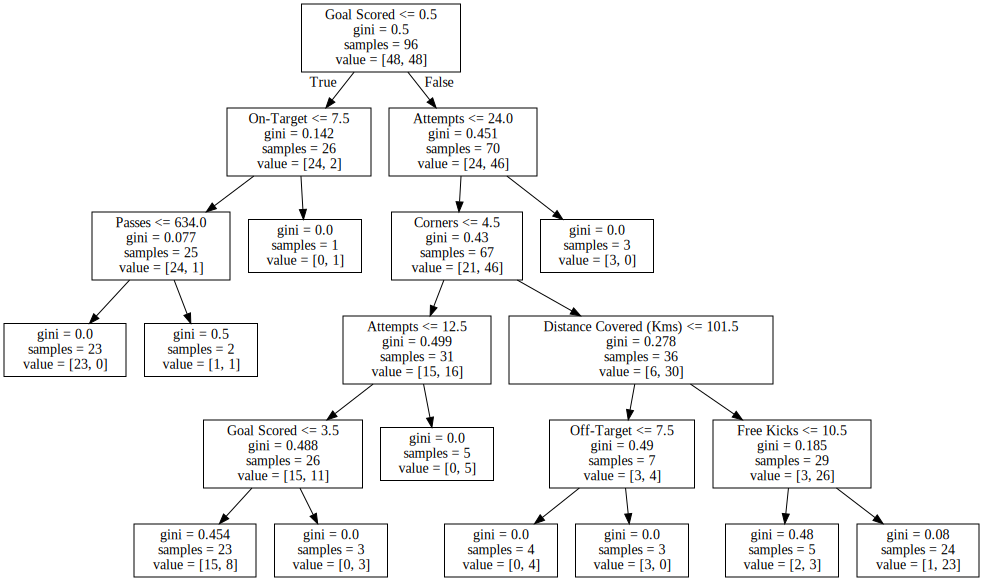

In [21]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names)
graphviz.Source(tree_graph)

### As guidance to read the tree:

Leaves with children show their splitting criterion on the top
The pair of values at the bottom show the count of False values and True values for the target respectively, of data points in that node of the tree.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


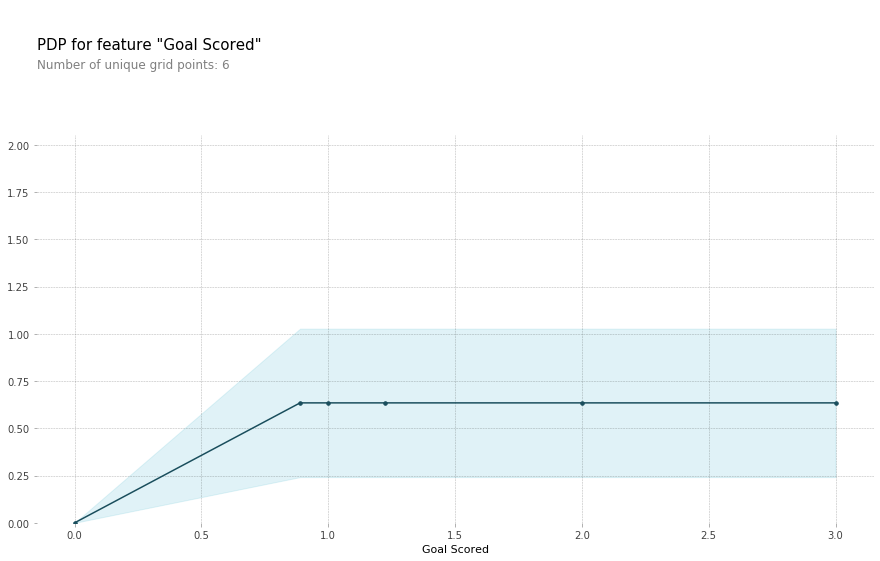

In [25]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature='Goal Scored')

# plot it
pdp.pdp_plot(pdp_goals, 'Goal Scored')
plt.show()

A few items are worth pointing out as you interpret this plot

* The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
* A blue shaded area indicates level of confidence

From this particular graph, we see that scoring a goal substantially increases your chances of winning "Man of The Match." But extra goals beyond that appear to have little impact on predictions.

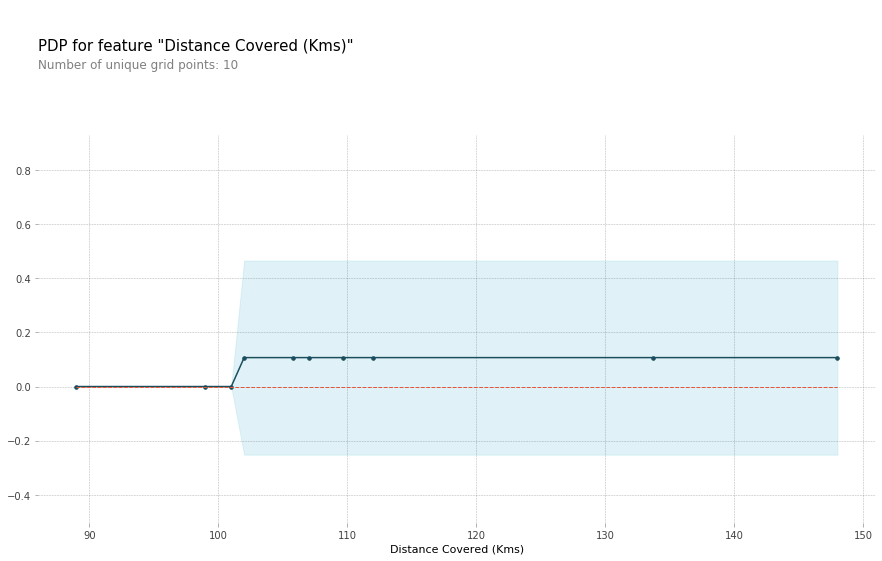

In [26]:
feature_to_plot = 'Distance Covered (Kms)'
pdp_dist = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

This graph seems too simple to represent reality. But that's because the model is so simple. You should be able to see from the decision tree above that this is representing exactly the model's structure.

You can easily compare the structure or implications of different models. Here is the same plot with a Random Forest model.

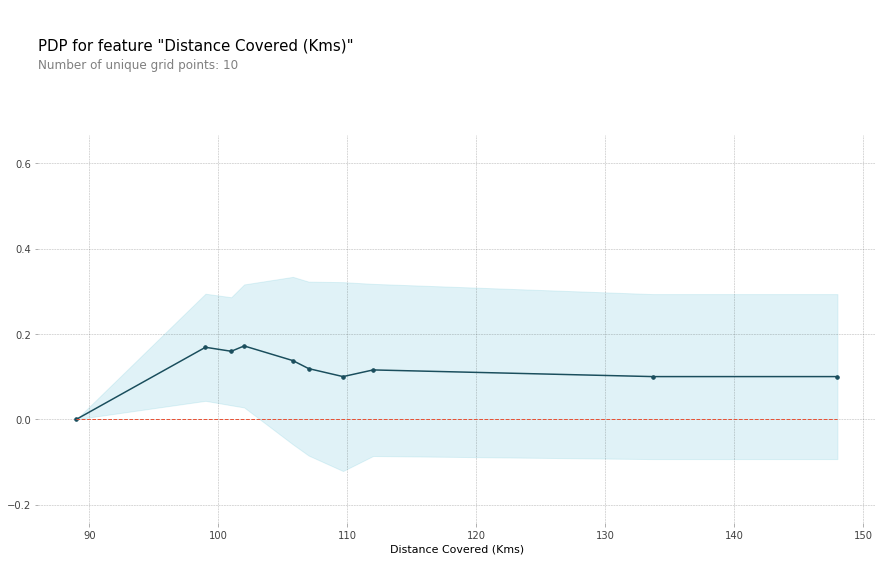

In [27]:
# Build Random Forest model
rf_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

pdp_dist = pdp.pdp_isolate(model=rf_model, dataset=val_X, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

This model thinks you are more likely to win Man of the Match if your players run a total of 100km over the course of the game. Though running much more causes lower predictions.

In general, the smooth shape of this curve seems more plausible than the step function from the Decision Tree model. Though this dataset is small enough that we would be careful in how we interpret any model.

### 2D Partial Dependence Plots

If you are curious about interactions between features, 2D partial dependence plots are also useful. An example may clarify this.

We will again use the Decision Tree model for this graph. It will create an extremely simple plot, but you should be able to match what you see in the plot to the tree itself.

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

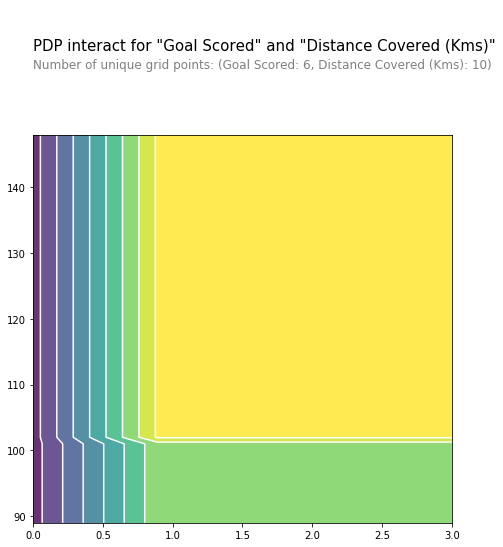

In [28]:
# Similar to previous PDP plot except we use pdp_interact instead of pdp_isolate and pdp_interact_plot instead of pdp_isolate_plot
features_to_plot = ['Goal Scored', 'Distance Covered (Kms)']
inter1  =  pdp.pdp_interact(model=tree_model, dataset=val_X, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

This graph shows predictions for any combination of Goals Scored and Distance covered.

For example, we see the highest predictions when a team scores at least 1 goal and they run a total distance close to 100km. If they score 0 goals, distance covered doesn't matter. Can you see this by tracing through the decision tree with 0 goals?

But distance can impact predictions if they score goals. Make sure you can see this from the 2D partial dependence plot. Can you see this pattern in the decision tree too?

### Another Example

In [32]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Data manipulation code below here
data = pd.read_csv('train.csv', nrows=50000)

# Remove data with extreme outlier coordinates or negative fares
data = data.query('pickup_latitude > 40.7 and pickup_latitude < 40.8 and ' +
                  'dropoff_latitude > 40.7 and dropoff_latitude < 40.8 and ' +
                  'pickup_longitude > -74 and pickup_longitude < -73.9 and ' +
                  'dropoff_longitude > -74 and dropoff_longitude < -73.9 and ' +
                  'fare_amount > 0'
                  )

y = data.fare_amount

base_features = ['pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude']

X = data[base_features]


train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
first_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(train_X, train_y)
print("Data sample:")
data.head()

Data sample:


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1


In [33]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,31289.000000,31289.000000,31289.000000,31289.000000,31289.000000,31289.000000
mean,8.483093,-73.976860,40.756917,-73.975342,40.757473,1.656141
std,4.628164,0.014635,0.018170,0.015917,0.018661,1.284899
min,0.010000,-73.999999,40.700013,-73.999999,40.700020,0.000000
25%,5.500000,-73.988039,40.744947,-73.987125,40.745922,1.000000
50%,7.500000,-73.979691,40.758027,-73.978547,40.758559,1.000000
75%,10.100000,-73.967823,40.769580,-73.966435,40.770427,2.000000
max,165.000000,-73.900062,40.799952,-73.900062,40.799999,6.000000


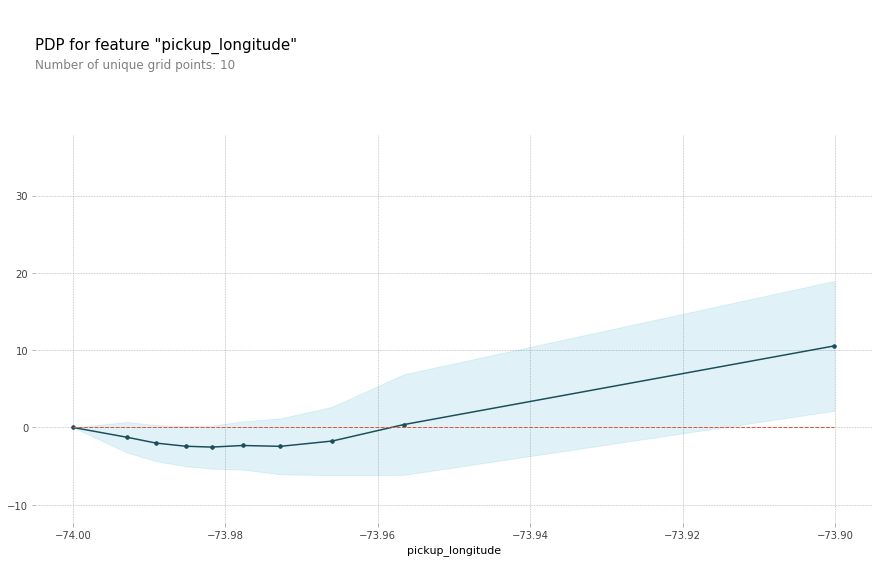

In [34]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

feat_name = 'pickup_longitude'
pdp_dist = pdp.pdp_isolate(model=first_model, dataset=val_X, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

### Question 1

Why does the partial dependence plot have this U-shape?

Does your explanation suggest what shape to expect in the partial dependence plots for the other features?

Create all other partial plots in a for-loop below (copying the appropriate lines from the code above).

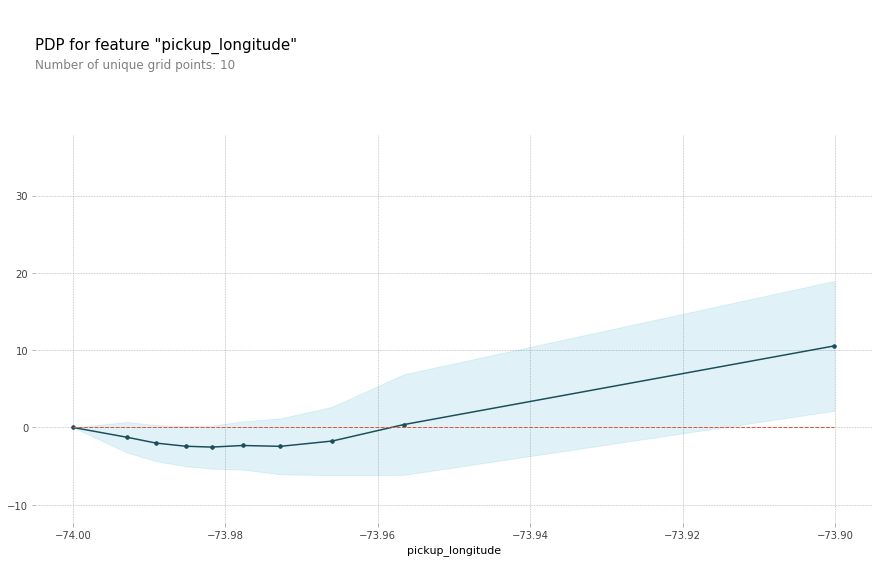

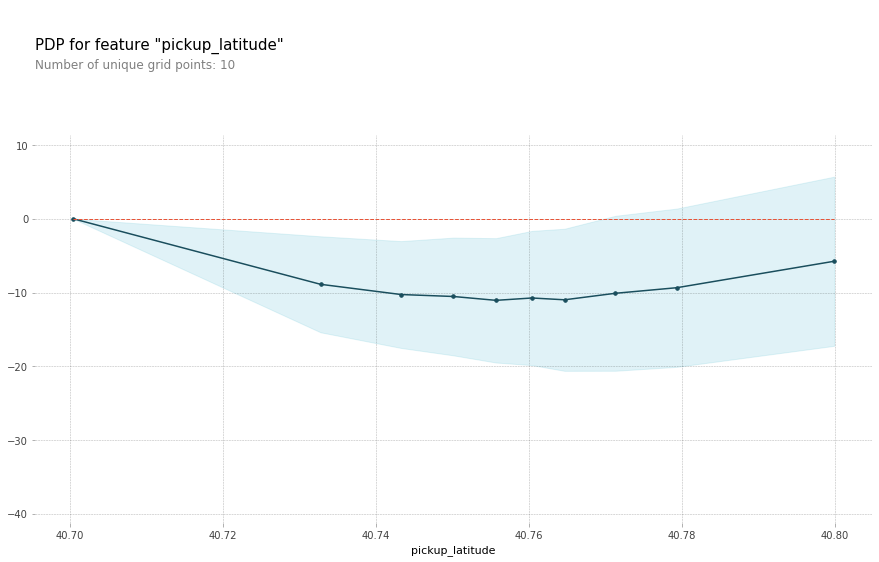

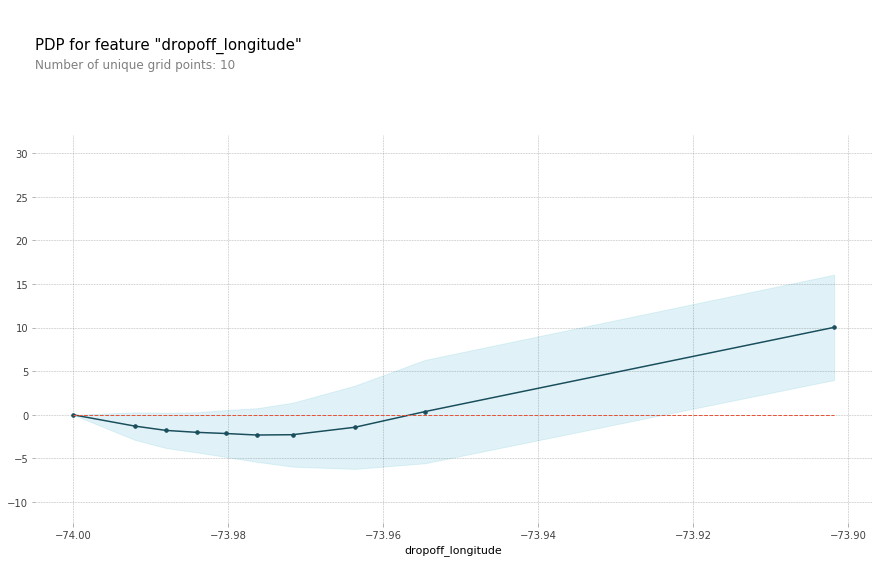

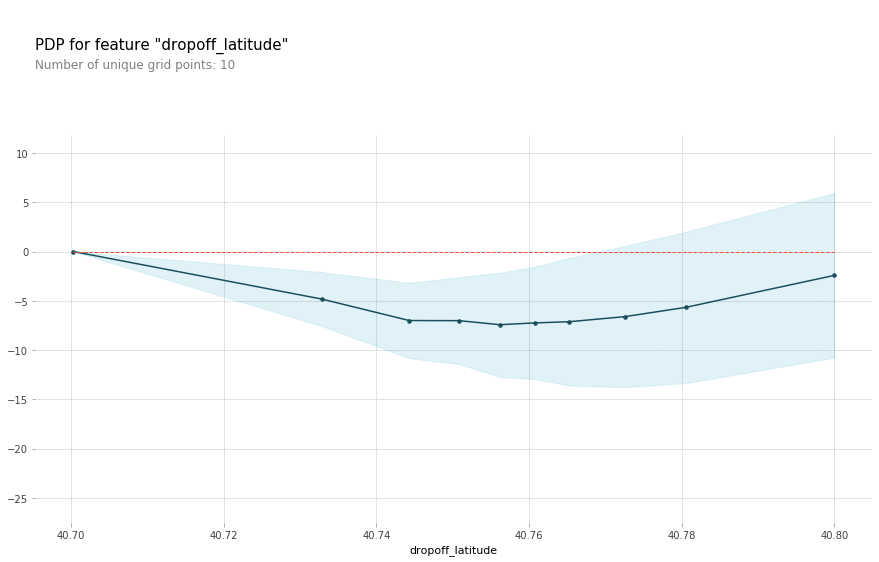

In [35]:
for feat_name in base_features:
    pdp_dist = pdp.pdp_isolate(model=first_model, dataset=val_X,
                               model_features=base_features, feature=feat_name)
    pdp.pdp_plot(pdp_dist, feat_name)
    plt.show()

We have a sense from the permutation importance results that distance is the most important determinant of taxi fare.

This model didn't include distance measures (like absolute change in latitude or longitude) as features, so coordinate features (like pickup_longitude) capture the effect of distance. Being picked up near the center of the longitude values lowers predicted fares on average, because it means shorter trips (on average).

For the same reason, we see the general U-shape in all our partial dependence plots.

### Question 2

Now you will run a 2D partial dependence plot. As a reminder, here is the code from the tutorial. What do you expect it to look like?

You should expect the plot to have contours running along a diagonal. We see that to some extent, though there are interesting caveats.

We expect the diagonal contours because these are pairs of values where the pickup and dropoff longitudes are nearby, indicating shorter trips (controlling for other factors).

As you get further from the central diagonal, we should expect prices to increase as the distances between the pickup and dropoff longitudes also increase.

The surprising feature is that prices increase as you go further to the upper-right of this graph, even staying near that 45-degree line.

This could be worth further investigation, though the effect of moving to the upper right of this graph is small compared to moving away from that 45-degree line.

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

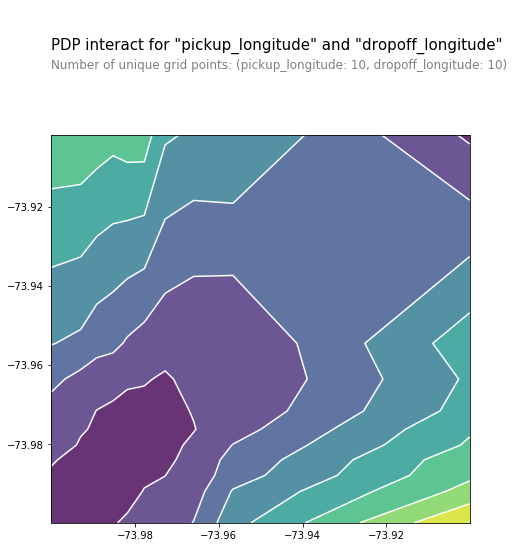

In [36]:
fnames = ['pickup_longitude', 'dropoff_longitude']
longitudes_partial_plot  =  pdp.pdp_interact(model=first_model, dataset=val_X,
                                            model_features=base_features, features=fnames)
pdp.pdp_interact_plot(pdp_interact_out=longitudes_partial_plot,
                      feature_names=fnames, plot_type='contour')
plt.show()

### Question 3

Consider a ride starting at longitude -73.92 and ending at longitude -74. Using the graph from the last question, estimate how much money the rider would have saved if they'd started the ride at longitude -73.98 instead?

First find the vertical level corresponding to -74 dropoff longitude. Then read off the horizontal values you are switching between. Use the white contour lines to orient yourself on what values you are near. You can round to the nearest integer rather than stressing about the exact cost to the nearest penny

About 15. The price decreases from slightly more than 24 to slightly more than 9.

### Question 4

In the PDP's you've seen so far, location features have primarily served as a proxy to capture distance traveled. In the permutation importance lessons, you added the features abs_lon_change and abs_lat_change as a more direct measure of distance.

Create these features again here. You only need to fill in the top two lines. Then run the following cell.

After you run it, identify the most important difference between this partial dependence plot and the one you got without absolute value features. The code to generate the PDP without absolute value features is at the top of this code cell.

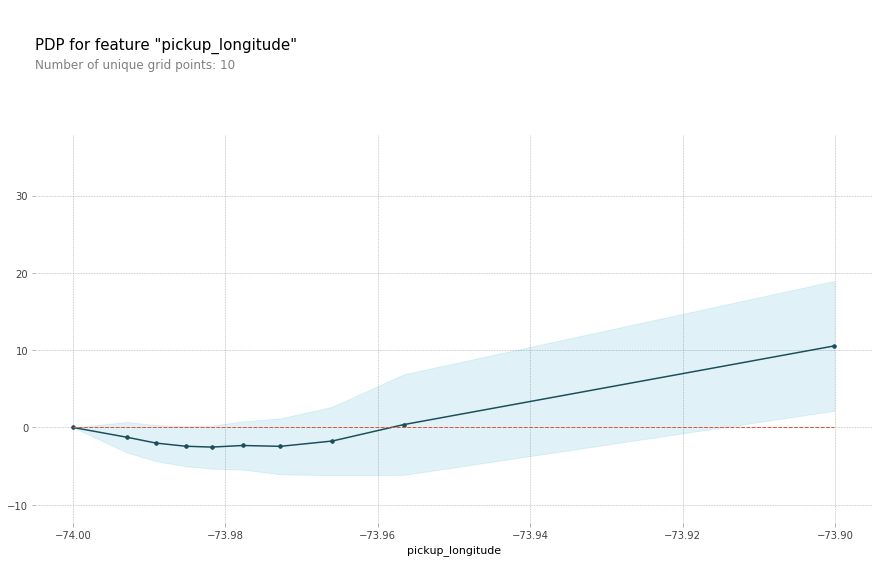

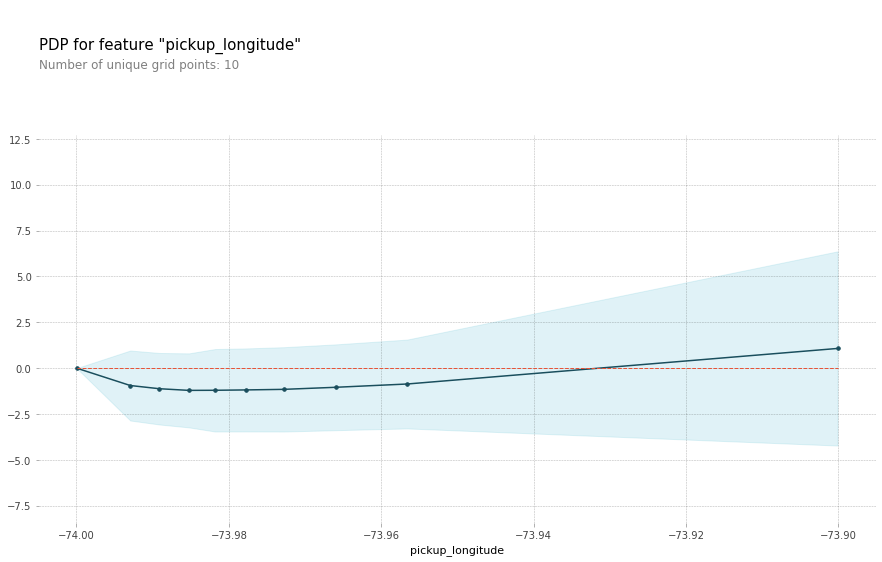

In [38]:
# This is the PDP for pickup_longitude without the absolute difference features. Included here to help compare it to the new PDP you create
feat_name = 'pickup_longitude'
pdp_dist_original = pdp.pdp_isolate(model=first_model, dataset=val_X, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist_original, feat_name)
plt.show()

# create new features
data['abs_lon_change'] = abs(data.dropoff_longitude - data.pickup_longitude)
data['abs_lat_change'] = abs(data.dropoff_latitude - data.pickup_latitude)

features_2  = ['pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'abs_lat_change',
               'abs_lon_change']

X = data[features_2]
new_train_X, new_val_X, new_train_y, new_val_y = train_test_split(X, y, random_state=1)
second_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(new_train_X, new_train_y)

feat_name = 'pickup_longitude'
pdp_dist = pdp.pdp_isolate(model=second_model, dataset=new_val_X, model_features=features_2, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

The biggest difference is that the partial dependence plot became much smaller. The the lowest vertical value is about  15 below the highest vertical value in the top chart, where as this difference is only about 15 below the highest vertical value in the top chart,whereas this difference is only about 3 in the chart you just created. In other words, once you control for absolute distance traveled, the pickup_longitude has only a very small impact on predictions.

### Question 5

Consider a scenario where you have only 2 predictive features, which we will call feat_A and feat_B. Both features have minimum values of -1 and maximum values of 1. The partial dependence plot for feat_A increases steeply over its whole range, whereas the partial dependence plot for feature B increases at a slower rate (less steeply) over its whole range.

Does this guarantee that feat_A will have a higher permutation importance than feat_B. Why or why not?

No. This doesn't guarantee feat_a is more important. For example, feat_a could have a big effect in the cases where it varies, but could have a single value 99\% of the time. In that case, permuting feat_a wouldn't matter much, since most values would be unchanged.

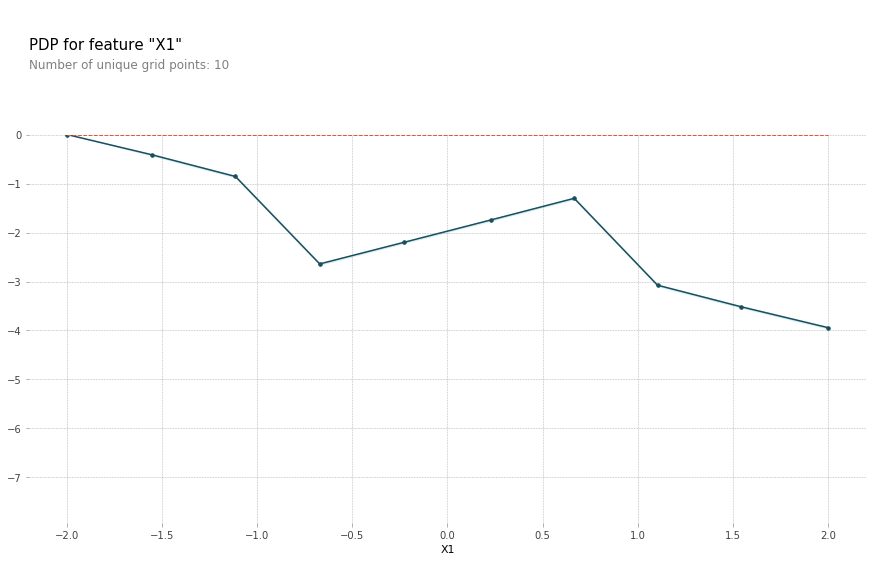

In [41]:
import numpy as np
from numpy.random import rand

n_samples = 20000

# Create array holding predictive feature
X1 = 4 * rand(n_samples) - 2
X2 = 4 * rand(n_samples) - 2
# Create y. you should have X1 and X2 in the expression for y
# y = np.ones(n_samples)
y = X1 - X2 -2 * X1 * (X1<-1) - 2 * X1 * (X1>1) 

# create dataframe because pdp_isolate expects a dataFrame as an argument
my_df = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})
predictors_df = my_df.drop(['y'], axis=1)

my_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(predictors_df, my_df.y)

pdp_dist = pdp.pdp_isolate(model=my_model, dataset=my_df, model_features=['X1', 'X2'], feature='X1')

# visualize your results
pdp.pdp_plot(pdp_dist, 'X1')
plt.show()


### Question 7

Create a dataset with 2 features and a target, such that the pdp of the first feature is flat, but its permutation importance is high. We will use a RandomForest for the model.

You need for X1 to affect the prediction in order to have it affect permutation importance. But the average effect needs to be 0 to satisfy the PDP requirement. Achieve this by creating an interaction, so the effect of X1 depends on the value of X2 and vice-versa.

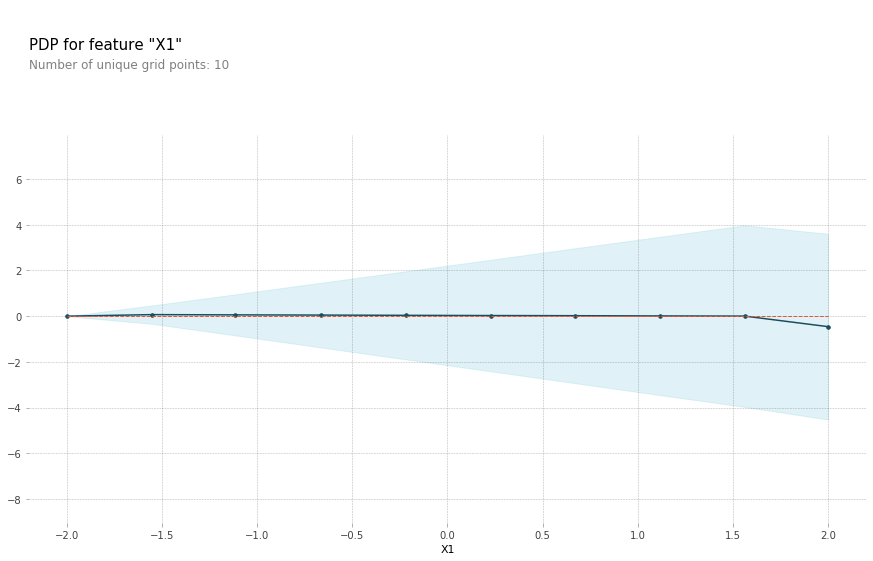

Weight,Feature
2.0090 ± 0.0257,X2
1.9866 ± 0.0336,X1


In [47]:
import eli5
from eli5.sklearn import PermutationImportance

n_samples = 20000

# Create array holding predictive feature
X1 = 4 * rand(n_samples) - 2
X2 = 4 * rand(n_samples) - 2
# Create y. you should have X in the expression for y
y = X1 * X2

# create dataframe because pdp_isolate expects a dataFrame as an argument
my_df = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})
predictors_df = my_df.drop(['y'], axis=1)

my_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(predictors_df, my_df.y)


pdp_dist = pdp.pdp_isolate(model=my_model, dataset=my_df, model_features=['X1', 'X2'], feature='X1')
pdp.pdp_plot(pdp_dist, 'X1')
plt.show()

perm = PermutationImportance(my_model).fit(predictors_df, my_df.y)

# show the weights for the permutation importance you just calculated
eli5.show_weights(perm, feature_names = ['X1', 'X2'])

## SHAP-Values

__SHAP Values__ (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. Where could you use this?

* A model says a bank shouldn't loan someone money, and the bank is legally required to explain the basis for each loan rejection
* A healthcare provider wants to identify what factors are driving each patient's risk of some disease so they can directly address those risk factors with targeted health interventions

You'll use SHAP Values to explain individual predictions in this lesson. In the next lesson, you'll see how these can be aggregated into powerful model-level insights.

### How They Work

SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

An example is helpful, and we'll continue the soccer/football example from the permutation importance and partial dependence plots lessons.

In these tutorials, we predicted whether a team would have a player win the Man of the Match award.

We could ask:

* How much was a prediction driven by the fact that the team scored 3 goals?

But it's easier to give a concrete, numeric answer if we restate this as:

* How much was a prediction driven by the fact that the team scored 3 goals, __instead of some baseline number of goals__.
Of course, each team has many features. So if we answer this question for number of goals, we could repeat the process for all other features.

SHAP values do this in a way that guarantees a nice property. Specifically, you decompose a prediction with the following equation:

sum(SHAP values for all features) = pred_for_team - pred_for_baseline_values

That is, the SHAP values of all features sum up to explain why my prediction was different from the baseline. 

This allows us to decompose a prediction in a graph like this:
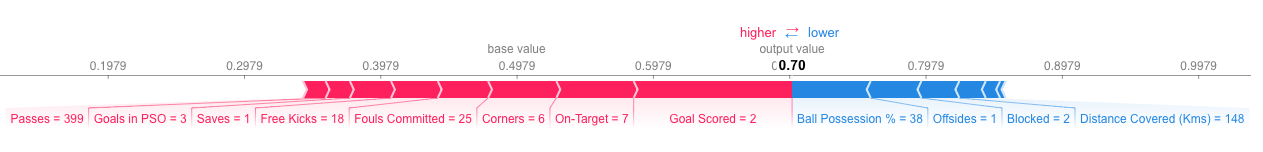

### How do you interpret this?

We predicted 0.7, whereas the base_value is 0.4979. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact comes from Goal Scored being 2. Though the ball possession value has a meaningful effect decreasing the prediction.

If you subtract the length of the blue bars from the length of the pink bars, it equals the distance from the base value to the output.

There is some complexity to the technique, to ensure that the baseline plus the sum of individual effects adds up to the prediction (which isn't as straightforward as it sounds).

### Code to Calculate SHAP Values

We calculate SHAP values using the wonderful Shap library.

For this example, we'll reuse the model you've already seen with the Soccer data.

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


We will look at SHAP values for a single row of the dataset (we arbitrarily chose row 5). For context, we'll look at the raw predictions before looking at the SHAP values.

In [8]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


my_model.predict_proba(data_for_prediction_array)

array([[0.3, 0.7]])

The team is 70% likely to have a player win the award.

Now, we'll move onto the code to get SHAP values for that single prediction.

In [9]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


The shap_values object above is a list with two arrays. The first array is the SHAP values for a negative outcome (don't win the award), and the second array is the list of SHAP values for the positive outcome (wins the award). We typically think about predictions in terms of the prediction of a positive outcome, so we'll pull out SHAP values for positive outcomes.

It's cumbersome to review raw arrays, but the shap package has a nice way to visualize the results.

In [10]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

If you look carefully at the code where we created the SHAP values, you'll notice we reference Trees in shap.TreeExplainer(my_model). But the SHAP package has explainers for every type of model.

* shap.DeepExplainer works with Deep Learning models.
* shap.KernelExplainer works with all models, though it is slower than other Explainers and it offers an approximation rather than exact Shap values.

Here is an example using KernelExplainer to get similar results. The results aren't identical because KernelExplainer gives an approximate result. But the results tell the same story.

In [12]:
# use Kernel SHAP to explain test set predictions

k_explainer = shap.KernelExplainer(my_model.predict_proba, train_X)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


### The Scenario

A hospital has struggled with "readmissions," where they release a patient before the patient has recovered enough, and the patient returns with health complications.

The hospital wants your help identifying patients at highest risk of being readmitted. Doctors (rather than your model) will make the final decision about when to release each patient; but they hope your model will highlight issues the doctors should consider when releasing a patient.

The hospital has given you relevant patient medical information. Here is a list of columns in the data:

In [14]:
import pandas as pd
data = pd.read_csv('hospital_data.csv')
data.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'race_Caucasian',
       'race_AfricanAmerican', 'gender_Female', 'age_[70-80)', 'age_[60-70)',
       'age_[50-60)', 'age_[80-90)', 'age_[40-50)', 'payer_code_?',
       'payer_code_MC', 'payer_code_HM', 'payer_code_SP', 'payer_code_BC',
       'medical_specialty_?', 'medical_specialty_InternalMedicine',
       'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_Cardiology', 'diag_1_428', 'diag_1_414',
       'diag_1_786', 'diag_2_276', 'diag_2_428', 'diag_2_250', 'diag_2_427',
       'diag_3_250', 'diag_3_401', 'diag_3_276', 'diag_3_428',
       'max_glu_serum_None', 'A1Cresult_None', 'metformin_No',
       'repaglinide_No', 'nateglinide_No', 'chlorpropamide_No',
       'glimepiride_No', 'acetohexamide_No', 'glipizide_No', 'glyburide_No',
     

Here are some quick hints at interpreting the field names:

* Your prediction target is readmitted
* Columns with the word diag indicate the diagnostic code of the illness or illnesses the patient was admitted with. For example, diag_1_428 means the doctor said their first illness diagnosis is number "428". What illness does 428 correspond to? You could look it up in a codebook, but without more medical background it wouldn't mean anything to you anyway.
* A column names like glimepiride_No mean the patient did not have the medicine glimepiride. If this feature had a value of False, then the patient did take the drug glimepiride
* Features whose names begin with medical_specialty describe the specialty of the doctor seeing the patient. The values in these fields are all True or False.

### Step 1
You have built a simple model, but the doctors say they don't know how to evaluate a model, and they'd like you to show them some evidence the model is doing something in line with their medical intuition. Create any graphics or tables that will show them a quick overview of what the model is doing?

They are very busy. So they want you to condense your model overview into just 1 or 2 graphics, rather than a long string of graphics.

We'll start after the point where you've built a basic model. Just run the following cell to build the model called `my_model`.

In [21]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

data = pd.read_csv('hospital_data.csv')

y = data.readmitted

base_features = [c for c in data.columns if c != "readmitted"]

X = data[base_features]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(train_X, train_y)


In [22]:
# Calculate and show permutation importance:
# Use permutation importance as a succinct model summary
# A measure of model performance on validation data would be useful here too
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.0451 ± 0.0068,number_inpatient
0.0087 ± 0.0046,number_emergency
0.0062 ± 0.0053,number_outpatient
0.0033 ± 0.0016,payer_code_MC
0.0020 ± 0.0016,diag_3_401
0.0016 ± 0.0031,medical_specialty_Emergency/Trauma
0.0014 ± 0.0024,A1Cresult_None
0.0014 ± 0.0021,medical_specialty_Family/GeneralPractice
0.0013 ± 0.0010,diag_2_427
0.0013 ± 0.0011,diag_2_276


### Step 2

It appears `number_inpatient` is a really important feature. The doctors would like to know more about that. Create a graph for them that shows how `num_inpatient` affects the model's predictions.

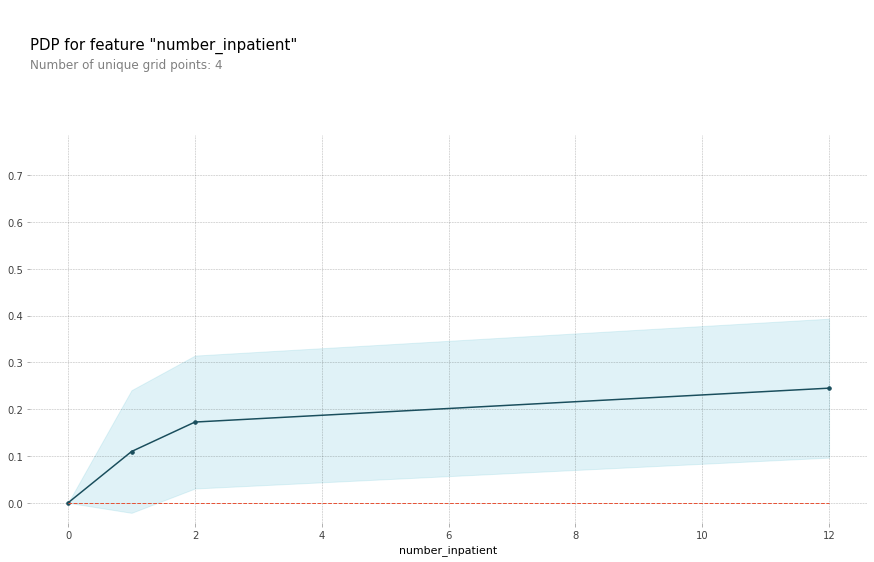

In [27]:
# PDP for number_inpatient feature

from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

feature_name = 'number_inpatient'
# Create the data that we will plot
my_pdp = pdp.pdp_isolate(model=my_model, dataset=val_X, model_features=val_X.columns, feature=feature_name)

# plot it
pdp.pdp_plot(my_pdp, feature_name)
plt.show()

In [26]:
# Calculate and show Shap Values for One Prediction
import shap  # package used to calculate Shap values

data_for_prediction = val_X.iloc[0,:]  # use 1 row of data here. Could use multiple rows if desired

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

### Step 3

The doctors think it's a good sign that increasing the number of inpatient procedures leads to increased predictions.  But they can't tell from this plot whether that change in the plot is big or small. They'd like you to create something similar for `time_in_hospital` to see how that compares.

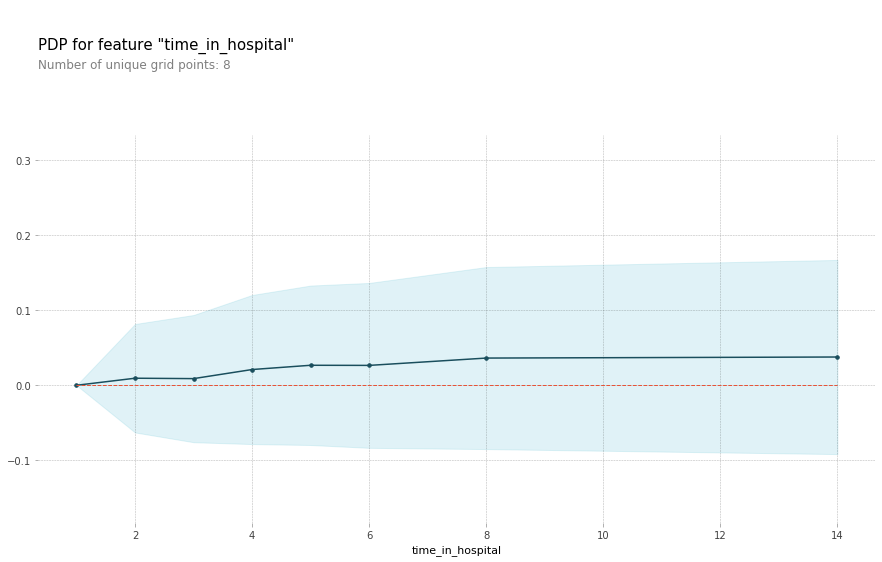

In [28]:

from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

feature_name = 'time_in_hospital'
# Create the data that we will plot
my_pdp = pdp.pdp_isolate(model=my_model, dataset=val_X, model_features=val_X.columns, feature=feature_name)

# plot it
pdp.pdp_plot(my_pdp, feature_name)
plt.show()

The results are very different. Specifically time in hospital has a much smaller effect.

### Step 4

Woah!  It seems like `time_in_hospital` doesn't matter at all.  The difference between the lowest value on the partial dependence plot and the highest value is about 5%.

If that is what your model concluded, the doctors will believe it. But it seems so low. Could  the data be wrong, or is your model doing something more complex than they expect?  

They'd like you to show them the raw readmission rate for each value of `time_in_hospital` to see how it compares to the partial dependence plot.

- Make that plot. 
- Are the results similar or different?

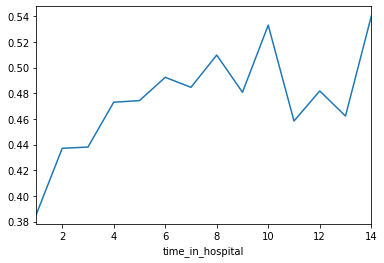

In [29]:
# A simple pandas groupby showing the average readmission rate for each time_in_hospital.

# Do concat to keep validation data separate, rather than using all original data
all_train = pd.concat([train_X, train_y], axis=1)

all_train.groupby(['time_in_hospital']).mean().readmitted.plot()
plt.show()

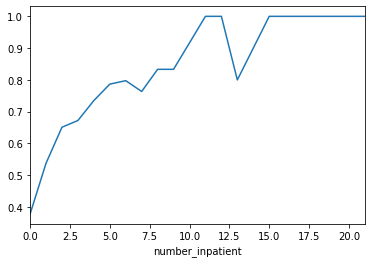

In [30]:
all_train.groupby(['number_inpatient']).mean().readmitted.plot()
plt.show()

### Step 5

Now the doctors are convinced you have the right data, and the model overview looked reasonable.  It's time to turn this into a finished product they can use. Specifically, the hospital wants you to create a function `patient_risk_factors` that does the following
- Takes a single row with patient data (of the same format you as your raw data)
- Creates a visualization showing what features of that patient increased their risk of readmission, what features decreased it, and how much those features mattered.

It's not important to show every feature with every miniscule impact on the readmission risk.  It's fine to focus on only the most important features for that patient.

In [31]:
# Use SHAP values to show the effect of each feature of a given patient

import shap  # package used to calculate Shap values

sample_data_for_prediction = val_X.iloc[0].astype(float)  # to test function

def patient_risk_factors(model, patient_data):
    # Create object that can calculate shap values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient_data)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient_data)

In [ ]:
patient_risk_factors(my_model, sample_data_for_prediction)

### Summary Plots

Permutation importance is great because it created simple numeric measures to see which features mattered to a model. This helped us make comparisons between features easily, and you can present the resulting graphs to non-technical audiences.

But it doesn't tell you how each features matter. If a feature has medium permutation importance, that could mean it has

* a large effect for a few predictions, but no effect in general, or
* a medium effect for all predictions.

SHAP summary plots give us a birds-eye view of feature importance and what is driving it. We'll walk through an example plot for the soccer data:



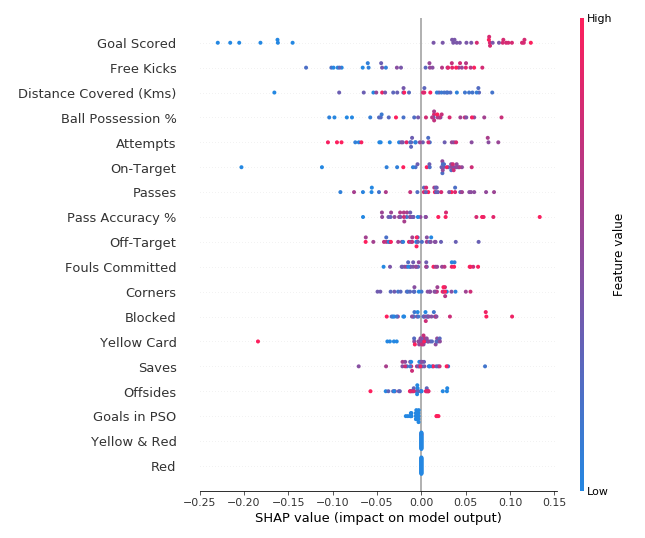

This plot is made of many dots. Each dot has three characteristics:

* Vertical location shows what feature it is depicting
* Color shows whether that feature was high or low for that row of the dataset
* Horizontal location shows whether the effect of that value caused a higher or lower prediction.

For example, the point in the upper left was for a team that scored few goals, reducing the prediction by 0.25.

Some things you should be able to easily pick out:

* The model ignored the Red and Yellow & Red features.
* Usually Yellow Card doesn't affect the prediction, but there is an extreme case where a high value caused a much lower prediction.
* High values of Goal scored caused higher predictions, and low values caused low predictions
* If you look for long enough, there's a lot of information in this graph. 

### Summary Plots in Code


In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

We get the SHAP values for all validation data with the following code. It is short enough that we explain it in the comments.

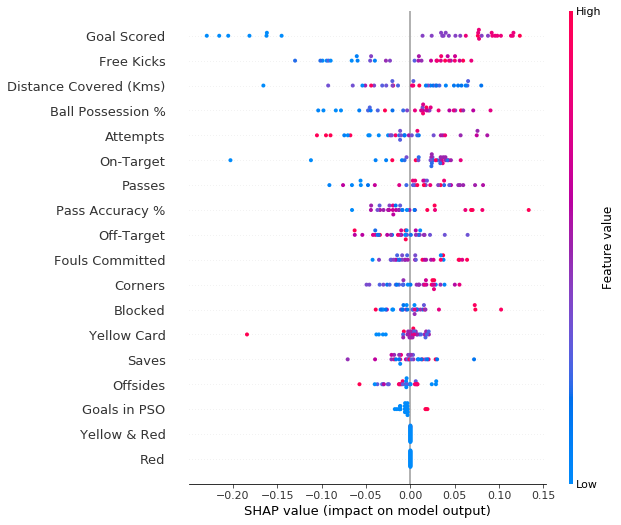

In [34]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], val_X)

The code isn't too complex. But there are a few caveats.

* When plotting, we call shap_values. For classification problems, there is a separate array of SHAP values for each possible outcome. In this case, we index in to get the SHAP values for the prediction of "True".
* Calculating SHAP values can be slow. It isn't a problem here, because this dataset is small. But you'll want to be careful when running these to plot with reasonably sized datasets. The exception is when using an xgboost model, which SHAP has some optimizations for and which is thus much faster.

This provides a great overview of the model, but we might want to delve into a single feature. That's where SHAP dependence contribution plots come into play.

### SHAP Dependence Contribution Plots

We've previously used Partial Dependence Plots to show how a single feature impacts predictions. These are insightful and relevant for many real-world use cases. Plus, with a little effort, they can be explained to a non-technical audience.

But there's a lot they don't show. For instance, what is the distribution of effects? Is the effect of having a certain value pretty constant, or does it vary a lot depending on the values of other feaures. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.

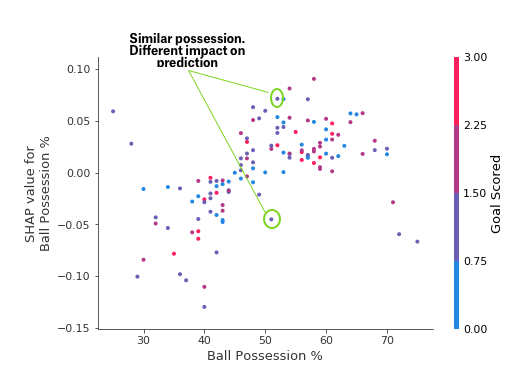

Start by focusing on the shape, and we'll come back to color in a minute. Each dot represents a row of the data. The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction. The fact this slopes upward says that the more you possess the ball, the higher the model's prediction is for winning the Man of the Match award.

The spread suggests that other features must interact with Ball Possession %. For example, here we have highlighted two points with similar ball possession values. That value caused one prediction to increase, and it caused the other prediction to decrease.

For comparison, a simple linear regression would produce plots that are perfect lines, without this spread.

This suggests we delve into the interactions, and the plots include color coding to help do that. While the primary trend is upward, you can visually inspect whether that varies by dot color.

Consider the following very narrow example for concreteness.

These two points stand out spatially as being far away from the upward trend. They are both colored purple, indicating the team scored one goal. You can interpret this to say __In general, having the ball increases a team's chance of having their player win the award. But if they only score one goal, that trend reverses and the award judges may penalize them for having the ball so much if they score that little.__

Outside of those few outliers, the interaction indicated by color isn't very dramatic here. But sometimes it will jump out at you.

### Dependence Contribution Plots in Code¶

We get the dependence contribution plot with the following code. The only line that's different from the summary_plot is the last line.

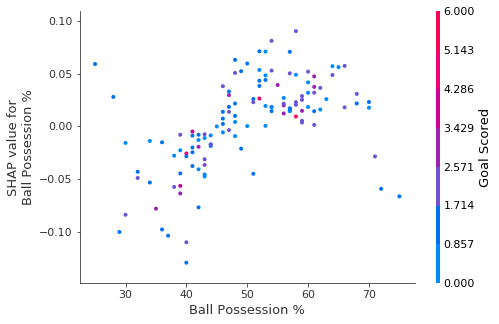

In [36]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X)

# make plot.
shap.dependence_plot('Ball Possession %', shap_values[1], X, interaction_index="Goal Scored")

If you don't supply an argument for interaction_index, Shapley uses some logic to pick one that may be interesting.

This didn't require writing a lot of code. But the trick with these techniques is in thinking critically about the results rather than writing code itself.

In [38]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

data = pd.read_csv('hospital_data.csv')
y = data.readmitted
base_features = ['number_inpatient', 'num_medications', 'number_diagnoses', 'num_lab_procedures', 
                 'num_procedures', 'time_in_hospital', 'number_outpatient', 'number_emergency', 
                 'gender_Female', 'payer_code_?', 'medical_specialty_?', 'diag_1_428', 'diag_1_414', 
                 'diabetesMed_Yes', 'A1Cresult_None']

# Some versions of shap package error when mixing bools and numerics
X = data[base_features].astype(float)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# For speed, we will calculate shap values on smaller subset of the validation data
small_val_X = val_X.iloc[:150]
my_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(train_X, train_y)

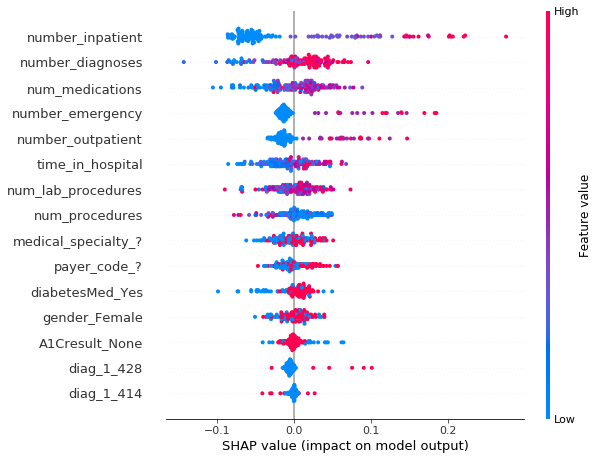

In [39]:
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(small_val_X)

shap.summary_plot(shap_values[1], small_val_X)

### Question 1

Which of the following features has a __bigger range of effects__ on predictions (i.e. larger difference between most positive and most negative effect)
- `diag_1_428` or
- `payer_code_?`

A: the range of diag_1_428 is wider, largely due to the few points on the far right.

### Question 2

Do you believe the range of effects sizes (distance between smallest effect and largest effect) is a good indication of which feature will have a higher permutation importance? Why or why not?  

If the **range of effect sizes** measures something different from **permutation importance**: which is a better answer for the question "Which of these two features does the model say is more important for us to understand when discussing readmission risks in the population?"

A: No. The width of the effects range is not a reasonable approximation to permutation importance. For that matter, the width of the range doesn't map well to any intuitive sense of "importance" because **it can be determined by just a few outliers**. However if all dots on the graph are widely spread from each other, that is a reasonable indication that permutation importance is high. Because the range of effects is so sensitive to outliers, **permutation importance is a better measure of what's generally important to the model**.

### Question 3

Both `diag_1_428` and `payer_code_?` are binary variables, taking values of 0 or 1.

From the graph, which do you think would typically have a bigger impact on predicted readmission risk:
- Changing `diag_1_428` from 0 to 1
- Changing `payer_code_?` from 0 to 1

A: While most SHAP values of diag_1_428 are small, the few pink dots (high values of the variable, corresponding to people with that diagnosis) have large SHAP values. In other words, the pink dots for this variable are far from 0, and making someone have the higher (pink) value would increase their readmission risk significantly. In real-world terms, this diagnosis is rare, but poses a larger risk for people who have it. In contrast, payer_code_? has many values of both blue and pink, and both have SHAP values that differ meaningfully from 0. But changing payer_code_? from 0 (blue) to 1 (pink) is likely to have a smaller impact than changing diag_1_428.

The variable "diag_1_428" if changing it to 1 has bigger effect

### Question 4

Some features (like `number_inpatient`) have reasonably clear separation between the blue and pink dots. Other variables like `num_lab_procedures` have blue and pink dots jumbled together, even though the SHAP values (or impacts on prediction) aren't all 0.

What do you think you learn from the fact that `num_lab_procedures` has blue and pink dots jumbled together? 

A: The jumbling suggests that sometimes increasing that feature leads to higher predictions, and other times it leads to a lower prediction. Said another way, both high and low values of the feature can have both positive and negative effects on the prediction. The most likely explanation for this "jumbling" of effects is that the variable (in this case num_lab_procedures) has an interaction effect with other variables. For example, there may be some diagnoses for which it is good to have many lab procedures, and other diagnoses where suggests increased risk. We don't yet know what other feature is interacting with num_lab_procedures though we could investigate that with SHAP contribution dependence plots.

### Question 5

Consider the following SHAP contribution dependence plot. 

The x-axis shows `feature_of_interest` and the points are colored based on `other_feature`.

![Imgur](https://i.imgur.com/zFdHneM.png)

Is there an interaction between `feature_of_interest` and `other_feature`?  
If so, does `feature_of_interest` have a more positive impact on predictions when `other_feature` is high or when `other_feature` is low?

A: First, recall that the SHAP vaue is an estimate of the impact of a given feature on the prediction. So, if the dots trend from upper left to lower right, that means low values of feature_of_interest cause higher predictions.

Returning to this graph:

feature_of_interest slopes downward for high values of other_feature. To see this, focus your eye on the pink dots (where other_feature is high) and imagine a best-fit line through those pink dots. It slopes down, suggesting that the prediction goes down as feature_of_interest increases.

Now focus your eye on the blue dots, and imagine a best fit line through those dots. It is generally pretty flat, possibly even curving up on the right side of the graph. So increasing feature_of_interest has a more positive impact on predictions when other_feature is high.

### Question 6

Both **num_medications** and **num_lab_procedures** share that jumbling of pink and blue dots.

Aside from `num_medications` having effects of greater magnitude (both more positive and more negative), it's hard to see a meaningful difference between how these two features affect readmission risk.  Create the SHAP dependence contribution plots for each variable, and describe what you think is different between how these two variables affect predictions.

As a reminder, here is the code you previously saw to create this type of plot.

    shap.dependence_plot(feature_of_interest, shap_values[1], val_X)
    
And recall that your validation data is called `small_val_X`.

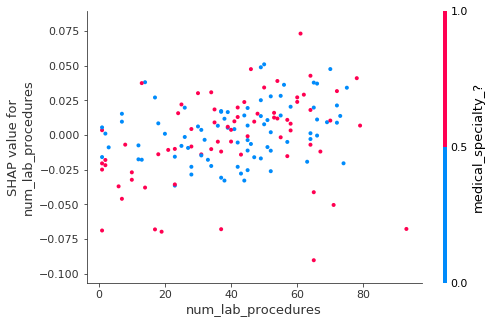

In [43]:
shap.dependence_plot('num_lab_procedures', shap_values[1], small_val_X)

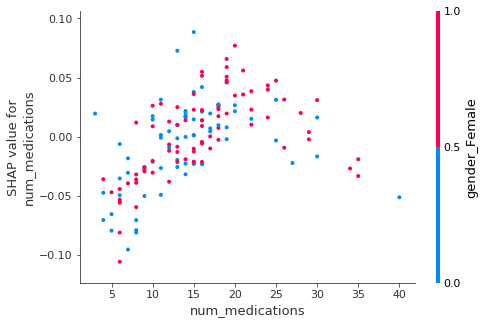

In [44]:

shap.dependence_plot('num_medications', shap_values[1], small_val_X)

Loosely speaking, num_lab_procedures looks like a cloud with little disernible pattern. It does not slope steeply up nor down at any point. It's hard to say we've learned much from that plot. At the same time, the values are not all very close to 0. So the model seems to think this is a relevant feature. One potential next step would be to explore more by coloring it with different other features to search for an interaction.

On the other hand, num_medications clearly slopes up until a value of about 20, and then it turns back down. Without more medical background, this seems a surprising phenomenon... You could do some exploration to see whether these patients have unusual values for other features too. But a good next step would be to discuss this phenomenon with domain experts (in this case, the doctors).